In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib  # For saving the scaler
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow.lite as tflite
import random


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [3]:
def preprocess_stock_data(
    csv_path, 
    date_column='Date', 
    close_column='Close', 
    test_size=0.2, 
    time_steps=60, 
    scaler_output_file='scaler.pkl'
):
    """
    Prepares stock market price data for time series modeling, with training and test split.

    Args:
        csv_path (str): Path to the CSV file containing the data.
        date_column (str): Name of the date column in the CSV.
        close_column (str): Name of the closing price column in the CSV.
        test_size (float): Proportion of the data for testing.
        time_steps (int): Number of past time steps to use for each sample.
        scaler_output_file (str): Path to save the fitted MinMaxScaler instance.

    Returns:
        X_train (numpy.ndarray): Training data (features).
        y_train (numpy.ndarray): Training labels.
        X_test (numpy.ndarray): Testing data (features).
        y_test (numpy.ndarray): Testing labels.
    """
    try:
        # Load the dataset
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"CSV file not found at path: {csv_path}")

        data = pd.read_csv(csv_path, parse_dates=[date_column])
        data.sort_values(by=date_column, inplace=True)

        print(f"CSV file successfully loaded. Columns: {data.columns}")
    except Exception as e:
        raise ValueError(f"Error reading CSV file or parsing date column '{date_column}': {e}")
    
    # Validate columns
    if date_column not in data.columns or close_column not in data.columns:
        raise ValueError(f"Columns '{date_column}' or '{close_column}' not found in dataset. Available columns: {data.columns}")

    try:
        # Extract the 'close' column for scaling
        close_prices = data[close_column].values.reshape(-1, 1)
    except Exception as e:
        raise ValueError(f"Error accessing '{close_column}' column: {e}")
    
    # Scale the data
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_close = scaler.fit_transform(close_prices)

        # Save the scaler to a file
        with open(scaler_output_file, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to {scaler_output_file}")
    except Exception as e:
        raise IOError(f"Error during scaling or saving scaler: {e}")
    
    # Create sequences of time_steps
    X, y = [], []
    try:
        for i in range(time_steps, len(scaled_close)):
            X.append(scaled_close[i - time_steps:i])
            y.append(scaled_close[i])
    except Exception as e:
        raise ValueError(f"Error creating sequences of time_steps: {e}")
    
    X, y = np.array(X), np.array(y)
    
    # Split data into train and test sets
    try:
        train_size = int((1 - test_size) * len(X))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
    except Exception as e:
        raise ValueError(f"Error splitting data into train and test sets: {e}")
    
    print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples")
    
    return X_train, y_train, X_test, y_test





In [4]:
data = "inputs/google_stock_cleaned.csv"


try:
    X_train, y_train, X_test, y_test = preprocess_stock_data(
        data, 
        date_column='Date', 
        close_column='Close', 
        test_size=0.2, 
        time_steps=60, 
        scaler_output_file='outputs/google_scale.pkl'
    )

    # Outputs
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"Unexpected Error: {e}")


CSV file successfully loaded. Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'daily_return', '20_day_ma', '50_day_ma'],
      dtype='object')
Scaler saved to outputs/google_scale.pkl
Data split: 554 training samples, 139 testing samples
X_train shape: (554, 60, 1), y_train shape: (554, 1)
X_test shape: (139, 60, 1), y_test shape: (139, 1)


In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (554, 60, 1)
y_train shape: (554, 1)


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

class StockPricePredictor_Google:
    def __init__(self, input_shape, learning_rate=0.0007971184552975506, num_layers=2, units=256):
        self.input_shape = input_shape  # Should be (time_steps, features)
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.units = units
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        for i in range(self.num_layers):
            # Add RNN layers
            return_sequences = i < (self.num_layers - 1)
            model.add(SimpleRNN(self.units, activation='relu', return_sequences=return_sequences, input_shape=self.input_shape))
            model.add(Dropout(0.2))  # Regularization

        # Output layer for regression (single output: close value)
        model.add(Dense(1))

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=tf.keras.losses.MeanSquaredError(),  # Explicitly use TensorFlow's implementation
            metrics=[tf.keras.metrics.MeanAbsoluteError()]  # Use TensorFlow's metric function
        )
        return model

    def train(self, X_train, y_train, batch_size=16, epochs=50, validation_data=None, patience=10):
        """
        Trains the model with an EarlyStopping callback.
        
        Args:
            X_train: Training input data.
            y_train: Training target data.
            batch_size: Batch size for training.
            epochs: Maximum number of training epochs.
            validation_data: Tuple (X_val, y_val) for validation.
            patience: Number of epochs with no improvement after which training will be stopped.
        
        Returns:
            History object containing training details.
        """
        # Validate and reshape the training data
        X_train = self._validate_and_reshape(X_train, expected_shape=(None, *self.input_shape))
        if validation_data:
            X_val = self._validate_and_reshape(validation_data[0], expected_shape=(None, *self.input_shape))
            validation_data = (X_val, validation_data[1])

        # Early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',  # Metric to monitor
            patience=patience,  # Number of epochs to wait before stopping
            restore_best_weights=True  # Restore model weights from the best epoch
        )

        # Train the model
        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=[early_stopping],  # Add the callback
            verbose=2
        )
        return history

    def predict(self, X):
        # Validate and reshape the input data
        X = self._validate_and_reshape(X, expected_shape=(None, *self.input_shape))
        return self.model.predict(X)

    def save(self, model_path):
        # Save the model
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    @staticmethod
    def load(model_path, scaler_path):
        # Load the model
        model = load_model(model_path)
        print(f"Model loaded from {model_path}")

        # Load the scaler
        scaler = joblib.load(scaler_path)
        print(f"Scaler loaded from {scaler_path}")

        return model, scaler

    def _validate_and_reshape(self, X, expected_shape):
        """
        Ensures input data has the correct shape for the model.
        
        Args:
            X: Input data to validate and reshape.
            expected_shape: Tuple representing the expected shape (e.g., (None, time_steps, features)).
        
        Returns:
            Reshaped data with the correct shape.
        """
        if len(X.shape) == 2:  # If shape is (num_samples, time_steps)
            reshaped = X[..., np.newaxis]  # Add a new axis for features
            print(f"Reshaped input from {X.shape} to {reshaped.shape}")
            return reshaped
        elif len(X.shape) == len(expected_shape):  # Correct shape
            print(f"Input shape is valid: {X.shape}")
            return X
        else:
            raise ValueError(f"Invalid input shape {X.shape}. Expected shape {expected_shape}.")


In [7]:
data_path_google = "inputs/google_stock_cleaned.csv"

#output_file = "scaled_stock_data_close_option.pkl"





In [8]:
if __name__ == "__main__":
    # Example input data
    input_shape = (60, 1)  # 60 time steps, 1 feature (e.g., close price)
    predictor = StockPricePredictor_Google(input_shape=input_shape)

    # Training
    predictor.train(X_train, y_train, validation_data=(X_test, y_test))

    # Prediction
    predictions = predictor.predict(X_test)

    
    model_path = "outputs/stock_price_rnn_model.keras"
    scaler_path = "outputs/google_scale.pkl"
    
    predictor.save(model_path)

    # Load model and scaler for inference
    loaded_model, loaded_scaler = StockPricePredictor_Google.load(model_path, scaler_path)
    predictions = loaded_model.predict(X_test)
    predictions_rescaled = loaded_scaler.inverse_transform(predictions)

    print("Predictions (rescaled):", predictions_rescaled)

    

Input shape is valid: (554, 60, 1)
Input shape is valid: (139, 60, 1)
Epoch 1/50


D:\stock_price_prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 - 4s - 122ms/step - loss: 0.0114 - mean_absolute_error: 0.0698 - val_loss: 0.0038 - val_mean_absolute_error: 0.0561
Epoch 2/50
35/35 - 1s - 37ms/step - loss: 0.0028 - mean_absolute_error: 0.0403 - val_loss: 0.0014 - val_mean_absolute_error: 0.0304
Epoch 3/50
35/35 - 1s - 36ms/step - loss: 0.0021 - mean_absolute_error: 0.0338 - val_loss: 9.7375e-04 - val_mean_absolute_error: 0.0246
Epoch 4/50
35/35 - 1s - 36ms/step - loss: 0.0019 - mean_absolute_error: 0.0333 - val_loss: 0.0011 - val_mean_absolute_error: 0.0265
Epoch 5/50
35/35 - 1s - 37ms/step - loss: 0.0016 - mean_absolute_error: 0.0305 - val_loss: 0.0011 - val_mean_absolute_error: 0.0266
Epoch 6/50
35/35 - 1s - 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0308 - val_loss: 0.0010 - val_mean_absolute_error: 0.0224
Epoch 7/50
35/35 - 1s - 36ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - val_loss: 0.0040 - val_mean_absolute_error: 0.0580
Epoch 8/50
35/35 - 1s - 36ms/step - loss: 0.0017 - mean_absolute_error: 0.0316 - v

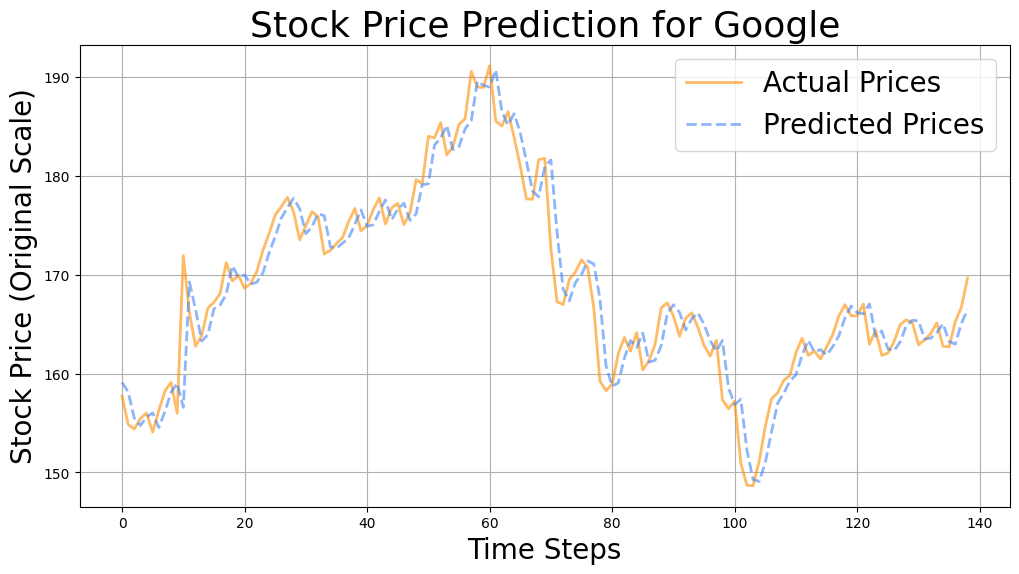

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(loaded_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Prices", color="darkorange", alpha=0.6, linewidth=2)
plt.plot(loaded_scaler.inverse_transform(predictions.reshape(-1, 1)), label="Predicted Prices", color="#4285F4", alpha=0.6, linestyle="--", linewidth=2)
plt.title("Stock Price Prediction for Google",fontsize = 26)
plt.xlabel("Time Steps",fontsize = 20)
plt.ylabel("Stock Price (Original Scale)",fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

In [10]:

import tensorflow as tf

# Path to your Keras model file
keras_model_path = "outputs/stock_price_rnn_model.keras"

# Load the Keras model
model = tf.keras.models.load_model(keras_model_path)

# Initialize the TFLite converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable experimental resource variable support to handle RNNs and stateful layers
converter.experimental_enable_resource_variables = True

# Optional: Add optimizations (e.g., quantization) for smaller and faster models
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Perform the conversion
try:
    tflite_model = converter.convert()
    # Save the converted TFLite model
    tflite_model_path = "outputs/stock_price_rnn_model.tflite"
    with open(tflite_model_path, "wb") as f:
        f.write(tflite_model)
    print(f"Model successfully converted to TFLite and saved at: {tflite_model_path}")
except Exception as e:  # General exception handling
    print(f"Error during TFLite conversion: {e}")



INFO:tensorflow:Assets written to: C:\Users\Kuzey\AppData\Local\Temp\tmp6eoeeqk2\assets


INFO:tensorflow:Assets written to: C:\Users\Kuzey\AppData\Local\Temp\tmp6eoeeqk2\assets


Saved artifact at 'C:\Users\Kuzey\AppData\Local\Temp\tmp6eoeeqk2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2279336002960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336010448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336009488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336010064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336012752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336011792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336012368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2279336014096: TensorSpec(shape=(), dtype=tf.resource, name=None)
Error during TFLite conversion: Variable constant folding is failed. Please consider using enabling `experimental_enable_resource_variables` flag in t